# Preprocessing FEX data

## How to preprocess and analyze facial expression data with Feat.

*Written by Jin Hyun Cheong*

Here we will be using a sample dataset by David Watson on ["A Data-Driven Characterisation Of Natural Facial Expressions When Giving Good And Bad News"](https://journals.plos.org/ploscompbiol/article/peerReview?id=10.1371/journal.pcbi.1008335) by Watson & Johnston 2020. The full dataset is available on [OSF](https://osf.io/6tbwj/).

Let's start by installing Py-FEAT if you have not already done so or using this on Google Colab

In [ ]:
!pip install -q py-feat

First, we download the necessary files & videos. 

In [1]:
import subprocess
# files_to_download = ["4c5mb", "n6rt3", "3gh8v", "twqxs", "nc7d9", "nrwcm", "2rk9c", "mxkzq", "c2na7", "wj7zy", "mxywn", 
#                      "6bn3g", "jkwsp", "54gtv", "c3hpm", "utdqj", "hpw4a", "94swe", "qte5y", "aykvu", "3d5ry"]

for fid in files_to_download:
    subprocess.run(f"wget --content-disposition https://osf.io/{fid}/download".split())

Check that videos have been downloaded and the attributes file, `clip_attrs.csv) explaining 

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os, glob
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("talk")

clip_attrs = pd.read_csv("clip_attrs.csv")
# videos = np.sort(glob.glob("*.mp4"))
videos = np.sort(glob.glob("../../../../watsondata/*.mp4"))[134:]

print(videos)

Process each video using our detector. 

In [22]:
from feat import Detector
detector = Detector(au_model = "rf", emotion_model = "resmasknet")
for video in videos: 
    detector.detect_video(video, outputFname = video.replace(".mp4", ".csv"))

Loading Face Detection model:  retinaface
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/mobilenet0.25_Final.pth
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/mobilenet_224_model_best_gdconv_external.pth.tar
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/hog_pca_all_emotio.joblib
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/hog_pca_all_emotio.joblib
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/hog_scalar_aus.joblib
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/RF_568.joblib
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/hog_pca_all_emotio.joblib
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/hog_scalar_aus.joblib
Using downloaded and verified file: /home/jcheong/packages/feat/feat/resources/ResMaskNet_Z_resmasking_dropout1_rot30

Load the saved output data using the `read_feat` function

In [3]:
from feat.utils import read_feat
import pandas as pd

for ix ,video in enumerate(videos):
    outputF = video.replace(".mp4", ".csv")
    if ix == 0: 
        fex = read_feat(outputF)
    else:
        fex = pd.concat([fex, read_feat(outputF)])
fex = fex.dropna()

In [4]:
# Load in conditions
clip_attrs = pd.read_csv("clip_attrs.csv")
clip_attrs = clip_attrs.assign(input = clip_attrs.clipN.apply(lambda x: str(x).zfill(3)+".mp4"),
                               condition = clip_attrs['class'].replace({"gn":"goodNews", "ists":"badNews"}))
input_class_map = dict(zip(clip_attrs.input, clip_attrs['condition']))
clip_attrs.head()

,clipN,class,phraseN,phrase_txt,input,condition
0,1,gn,1,your loan has been approved,001.mp4,goodNews
1,2,gn,2,you've got the job,002.mp4,goodNews
2,3,gn,3,the vendor has accepted your offer,003.mp4,goodNews
3,4,gn,4,your tests have come back clear,004.mp4,goodNews
4,5,gn,5,your application has been accepted,005.mp4,goodNews


## Extract features
You can set the `sessions` attribute to provide a grouping of your experimental setup. This could be the name of each video if you want to extract features per video or it could be conditions to extract features per condition. 

In [5]:
# Extract conditions between the two condtiiosn (gn: good news, ists: bad news)
conditions = dict(zip(clip_attrs.input, clip_attrs['condition']))
fex.sessions = fex.input().map(conditions)
average_au_intensity_per_video = fex.extract_mean()
display(average_au_intensity_per_video.head())

,mean_AU01,mean_AU02,mean_AU04,mean_AU05,mean_AU06,mean_AU07,mean_AU09,mean_AU10,mean_AU11,mean_AU12,...,mean_y_61,mean_y_62,mean_y_63,mean_y_64,mean_y_65,mean_y_66,mean_y_67,mean_y_7,mean_y_8,mean_y_9
badNews,0.370603,0.347909,0.274446,0.470608,0.144680,0.350956,0.057206,0.367228,0.414330,0.245751,...,714.571030,715.994335,711.230906,703.585629,715.312303,720.341735,718.979703,823.783636,827.212203,813.770216
goodNews,0.437070,0.399585,0.209061,0.219561,0.641241,0.642395,0.161864,0.775689,0.412116,0.814605,...,684.355943,686.797688,683.110011,676.147267,693.425396,697.551264,695.402943,810.933791,817.027471,806.257672


Or simply extract features per video

In [6]:
# Extract features per video
fex.sessions = fex.input()
average_au_intensity_per_video = fex.extract_mean()
display(average_au_intensity_per_video.head())

,mean_AU01,mean_AU02,mean_AU04,mean_AU05,mean_AU06,mean_AU07,mean_AU09,mean_AU10,mean_AU11,mean_AU12,...,mean_y_61,mean_y_62,mean_y_63,mean_y_64,mean_y_65,mean_y_66,mean_y_67,mean_y_7,mean_y_8,mean_y_9
001.mp4,0.367902,0.304953,0.217278,0.247205,0.529641,0.546710,0.127434,0.689482,0.405150,0.757060,...,694.305659,696.236139,692.150659,682.592831,696.408174,700.882806,699.187324,814.856982,819.742603,808.427911
002.mp4,0.384290,0.372414,0.218073,0.238233,0.466245,0.568260,0.139705,0.645774,0.406103,0.665162,...,686.464658,688.592334,685.344299,677.572549,688.540245,692.234408,690.349490,806.882534,812.669819,802.669351
003.mp4,0.475926,0.435061,0.193346,0.235034,0.628517,0.614398,0.130048,0.758156,0.406965,0.822223,...,678.527397,681.056783,677.828855,672.959971,688.190226,691.792301,689.539840,803.369594,810.371285,800.508759
004.mp4,0.465396,0.431265,0.215378,0.136780,0.719656,0.712953,0.195271,0.852897,0.413281,0.888342,...,682.179613,684.565805,680.513723,674.068777,694.367983,698.833575,696.740101,811.564575,817.511093,806.248735
005.mp4,0.358873,0.346983,0.196898,0.132950,0.729992,0.724506,0.230352,0.844839,0.421897,0.883427,...,701.603967,703.849507,699.122215,687.917109,711.293560,716.390717,714.357210,827.466633,833.453529,821.740933


# Analyzing FEX data
## Simple t-test
You can use a simple t-test to test if the average activation of a certain AU is significantly higher than .5 (chance). The results suggests that AU10 (upper lip raiser), 12 (lip corner puller), and 14 (dimpler) is significantly activitated when providing good news. 

In [7]:
average_au_intensity_per_video.sessions = average_au_intensity_per_video.index.map(input_class_map)
t, p = average_au_intensity_per_video[average_au_intensity_per_video.sessions=="goodNews"].aus().ttest_1samp(.5)
pd.DataFrame({"t": t, "p": p}, index= average_au_intensity_per_video.au_columns)

,t,p
mean_AU01,-2.927201,1.683346e-02
mean_AU02,-5.838201,2.473720e-04
mean_AU04,-49.805912,2.660164e-12
mean_AU05,-11.942339,8.022300e-07
mean_AU06,3.905366,3.589972e-03
mean_AU07,5.487334,3.864728e-04
mean_AU09,-22.647961,3.024835e-09
mean_AU10,10.361594,2.660301e-06
mean_AU11,-42.691265,1.059418e-11
mean_AU12,11.949046,7.984040e-07


## Two sample independent t-test
You can also perform an independent two sample ttest between two sessions which in this case is goodNews vs badNews.

In [ ]:
import matplotlib.pyplot as plt

columns2compare = "mean_AU12"
sessions = ("goodNews", "badNews")
t, p = average_au_intensity_per_video.ttest_ind(col = columns2compare, sessions=sessions)
print(f"T-test between {sessions[0]} vs {sessions[1]}: t={t:.2g}, p={p:.3g}")
with sns.plotting_context("poster", font_scale=1):
    f,ax = plt.subplots(figsize=(5,7))
    sns.barplot(x = average_au_intensity_per_video.sessions, 
                y = columns2compare, 
                data = average_au_intensity_per_video);
    ax.set(ylim=[0,1.3], yticks=[0, .4, .8, 1.2], ylabel="mean AU12\nintensity")
    sns.despine()

In [128]:
fig_df = average_au_intensity_per_video.reset_index()[["index", "mean_AU01", "mean_AU12","mean_AU17"]]
fig_df.columns = ['index', '1', '12', '17']
fig_df = fig_df.melt(id_vars="index", 
                       value_vars= ['1', '12', '17'],
                       var_name = "Action Units",
                       value_name = "Average intensity")
fig_df = fig_df.assign(condition=fig_df['index'].map(input_class_map))

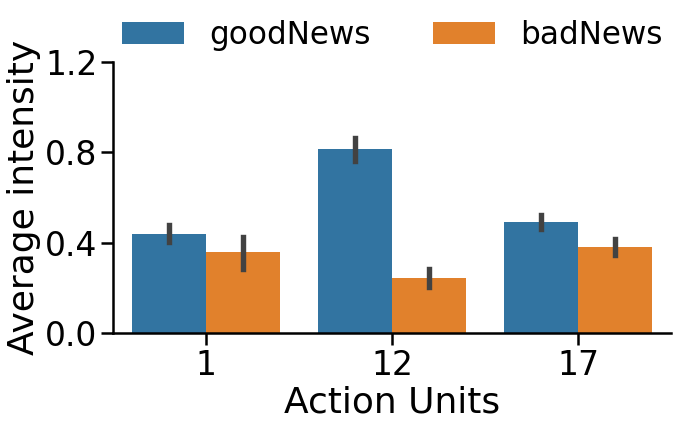

In [129]:
with sns.plotting_context("poster", font_scale=1.5):
    f,ax = plt.subplots(figsize=(10,5))
    sns.barplot(x="Action Units", y="Average intensity", data=fig_df, hue='condition', ax=ax)
    ax.set(ylim=[0,1.2], yticks=[0, .4, .8, 1.2], ylabel="Average intensity")
    sns.despine()
plt.legend(bbox_to_anchor=(0.5, 1.2), loc=9, borderaxespad=0., ncol=2, fontsize="xx-large", frameon=False)

In [119]:
plt.legend?

## Prediction
If you want to know what combination of features predic the good news or bad news conditions. To investigate this problem, we can train a Logistc Regression model using emotion labels to predict the conditions. Results suggest that detections of happy expressions predict the delivery of good news. 

In [10]:
fex.sessions = fex.input().map(input_class_map)

from sklearn.linear_model import LogisticRegression
clf = fex.predict(X=fex.emotions(), y = fex.sessions, model = LogisticRegression, solver="liblinear")
print(f"score: {clf.score(fex.emotions(), fex.sessions):.3g}")
print(f"coefficients for predicting class: {clf.classes_[1]}")
display(pd.DataFrame(clf.coef_, columns = fex.emotions().columns))

score: 0.933
coefficients for predicting class: goodNews


,anger,disgust,fear,happiness,sadness,surprise,neutral
0,-0.722285,-0.566583,-2.868222,8.24894,-2.434085,-0.096825,-3.030539


Also run the same analysis with Action Units to predict goodNews

In [41]:
fex.sessions = fex.input().map(input_class_map)

from sklearn.linear_model import LogisticRegression
clf = fex.predict(X=fex.aus(), y = fex.sessions, model = LogisticRegression, solver="liblinear")
print(f"score: {clf.score(fex.aus(), fex.sessions):.3g}")
print(f"coefficients for predicting class: {clf.classes_[1]}")
display(pd.DataFrame(clf.coef_, columns = fex.aus().columns))

score: 0.939
coefficients for predicting class: goodNews


,AU01,AU02,AU04,AU05,AU06,AU07,AU09,AU10,AU11,AU12,AU14,AU15,AU17,AU20,AU23,AU24,AU25,AU26,AU28,AU43
0,-1.098812,-1.10724,-1.427921,-3.478431,3.398894,-0.058685,0.171162,0.700711,-1.149977,4.01383,-2.361226,-0.023872,3.206585,-0.585006,1.834217,-0.087748,-1.648902,1.5935,0.99891,-1.243184


<AxesSubplot:>

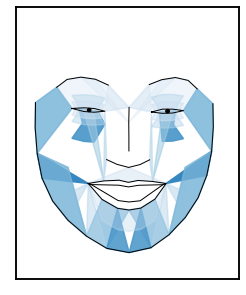

In [58]:
from feat import Fex
aus = Fex(pd.DataFrame(clf.coef_, columns = fex.aus().columns), 
          au_columns = fex.aus().columns,
         detector="feat")
aus.plot_aus(0, feature_range=(0,2), muscles = {'all': 'heatmap'})

<AxesSubplot:>

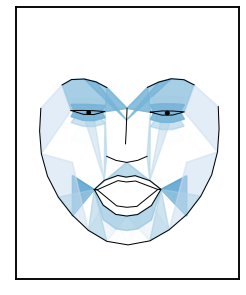

In [59]:
aus = Fex(pd.DataFrame(-clf.coef_, columns = fex.aus().columns), 
          au_columns = fex.aus().columns,
         detector="feat")
aus.plot_aus(0, feature_range=(0,2), muscles = {'all': 'heatmap'})

In [12]:
from sklearn.linear_model import LogisticRegression

from numpy.random import default_rng
average_au_intensity_per_video
ys = np.array(["goodNews"]*10 + ["badNews"]*10)
ys = pd.DataFrame({"y": ys}, index = average_au_intensity_per_video.index)

rng = default_rng(1)
goodNewsIdx = list(average_au_intensity_per_video.index[:10])
rng.shuffle(goodNewsIdx)
badNewsIdx = list(average_au_intensity_per_video.index[10:])
rng.shuffle(badNewsIdx)

scores = []
for gix, bix in zip(goodNewsIdx, badNewsIdx):
    trainX = average_au_intensity_per_video.query("index!=@gix and index!=@bix")
    trainY = ys.query("index!=@gix and index!=@bix").values.ravel()

    testX = average_au_intensity_per_video.query("index==@gix or index==@bix")
    testY = ys.query("index==@gix or index==@bix").values.ravel()

    clf = trainX.predict(X = trainX.au_columns, y = trainY, model = LogisticRegression)
    print(clf.predict(testX.aus()), testY)
    scores.append(clf.score(testX.aus(), testY))

clf = average_au_intensity_per_video.predict(average_au_intensity_per_video.au_columns, 
                                             ys.values.ravel(), 
                                             model = LogisticRegression)
print(scores)
print(f"coefficients for predicting class: {clf.classes_[1]}")
display(pd.DataFrame(clf.coef_, columns = fex.aus().columns))

['goodNews' 'badNews'] ['goodNews' 'badNews']
['goodNews' 'badNews'] ['goodNews' 'badNews']
['goodNews' 'badNews'] ['goodNews' 'badNews']
['goodNews' 'badNews'] ['goodNews' 'badNews']
['goodNews' 'badNews'] ['goodNews' 'badNews']
['goodNews' 'badNews'] ['goodNews' 'badNews']
['goodNews' 'badNews'] ['goodNews' 'badNews']
['goodNews' 'badNews'] ['goodNews' 'badNews']
['goodNews' 'badNews'] ['goodNews' 'badNews']
['goodNews' 'badNews'] ['goodNews' 'badNews']
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
coefficients for predicting class: goodNews


,AU01,AU02,AU04,AU05,AU06,AU07,AU09,AU10,AU11,AU12,AU14,AU15,AU17,AU20,AU23,AU24,AU25,AU26,AU28,AU43
0,0.150411,0.116888,-0.152369,-0.554531,1.071479,0.622543,0.218424,0.877264,-0.009832,1.256323,0.051967,0.263322,0.277144,0.080427,-0.017328,-0.557003,0.596009,0.281354,-0.00133,0.036538


<AxesSubplot:>

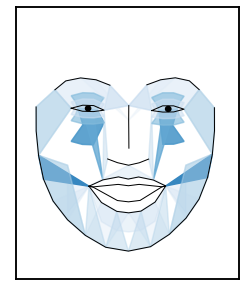

In [14]:
from feat import Fex
aus = Fex(pd.DataFrame(clf.coef_, columns = fex.aus().columns), 
          au_columns = fex.aus().columns,
         detector="feat")
aus.plot_aus(0, feature_range=(0,1), muscles = {'all': 'heatmap'})

<AxesSubplot:>

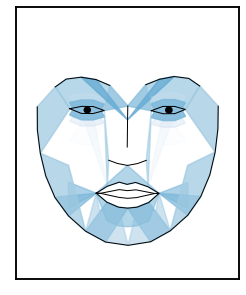

In [15]:
aus = Fex(pd.DataFrame(-clf.coef_, columns = fex.aus().columns), 
          au_columns = fex.aus().columns,
         detector="feat")
aus.plot_aus(0, feature_range=(0,1), muscles = {'all': 'heatmap'})

## Regression
We can also run an fMRI style regression to predict the Action Unit activities from a contrast of conditions. This analysis can be conducted through the `regress` method. In this example, we identify the action units that are significantly more active in the good news versus the bad news conditions.

In [16]:
fex.sessions = fex.input().map(input_class_map).replace({"goodNews":.5, "badNews":-.5})
X = pd.DataFrame(fex.sessions)
X['intercept'] = 1
b, t, p, df, residuals = fex.regress(X = X, y = fex.aus())
print("Betas predicting good news estimated for each emotion.")
results = pd.concat([b.round(3).loc[[0]].rename(index={0:"betas"}),
                    t.round(3).loc[[0]].rename(index={0:"t-stats"}),
                    p.round(3).loc[[0]].rename(index={0:"p-values"})])
display(results)

Betas predicting good news estimated for each emotion.


/home/jcheong/anaconda3/lib/python3.8/site-packages/nltools/stats.py:970: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  stderr = np.sqrt(np.diag(np.linalg.pinv(np.dot(X.T, X))))[:, np.newaxis] * sigma[np.newaxis, :]


,AU01,AU02,AU04,AU05,AU06,AU07,AU09,AU10,AU11,AU12,AU14,AU15,AU17,AU20,AU23,AU24,AU25,AU26,AU28,AU43
betas,0.066,0.052,-0.065,-0.251,0.497,0.291,0.105,0.408,-0.002,0.569,0.022,0.111,0.101,0.038,-0.029,-0.284,0.305,0.140,-0.016,0.013
t-stats,8.221,8.219,-17.153,-31.413,43.783,33.364,21.079,35.625,-2.671,46.713,4.088,17.515,15.673,7.927,-5.063,-22.483,19.415,16.822,-2.293,2.422
p-values,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.008,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.022,0.016


## Intersubject (or intervideo) correlations
To compare the similarity of signals over time between subjects or videos, you can use the `isc` method. You can get a sense of how much two signals, such as a certain action unit activity, correlates over time. 

In this example, we are calculating the ISC over videos. We want to check how similar AU01 activations are across videos so our session is set to the `input` which is the video name. Executing the `isc` method shows that the temporal profile of AU01 activations form two clusters between the goodNews and the badNews conditions. 

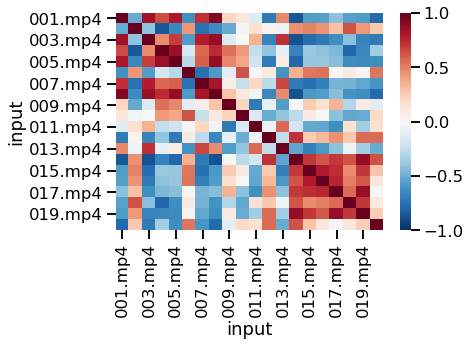

In [18]:
fex.sessions = fex.input()
isc = fex.isc(col = "AU01")
sns.heatmap(isc.corr(), center=0, vmin=-1, vmax=1, cmap="RdBu_r");